In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 

In [52]:
X_dev = pd.read_csv('X_dev.csv')
y_dev = pd.read_csv('y_dev.csv')

X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.3, random_state=42)

## Creating a new feature

In [53]:
def calculate_intensity(X):
    X['intensity']=X['g']+X['r']+X['i']+X['z']+X['u']
    return X
intensity_transformer = FunctionTransformer(calculate_intensity)

In [54]:
feature_engineering = Pipeline(steps=[
    ('intensity', intensity_transformer)
])
X_feature_engineered = feature_engineering.fit_transform(X_train)
X_val_feature_engineered = feature_engineering.transform(X_val)
X_feature_engineered

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID,intensity
68681,1.237651e+18,147.392648,0.145509,23.62785,21.78850,21.73961,21.88235,21.43752,1239,301,4,181,4.308885e+18,2.333820,3827,55565,240,110.47583
19961,1.237665e+18,157.156740,35.327317,18.60880,17.52187,17.12905,16.95103,16.89711,4518,301,6,192,2.204664e+18,0.043298,1958,53385,553,87.10786
11040,1.237667e+18,94.688025,63.535297,18.16716,16.51485,15.75641,15.35805,15.23041,5060,301,1,100,2.588464e+18,-0.000342,2299,53711,74,81.02688
27673,1.237655e+18,214.420238,-1.506597,19.83027,18.47293,17.82672,17.48600,17.26200,2334,301,5,124,1.032563e+18,0.081886,917,52400,411,90.87792
22876,1.237668e+18,204.749167,17.703206,19.33024,18.16558,17.74244,17.48129,17.32534,5314,301,1,181,2.935343e+18,0.061780,2607,54184,443,90.04489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,1.237679e+18,6.625787,4.523553,19.31572,17.34906,16.32559,15.77050,15.26476,7718,301,2,33,4.973125e+18,0.081446,4417,55829,91,84.02563
6265,1.237658e+18,139.553578,5.737747,23.55326,20.84679,20.52560,20.43124,20.46692,2986,301,5,141,5.483257e+18,3.153167,4870,55923,454,105.82381
54886,1.237662e+18,239.791229,32.183245,23.61472,21.55833,19.99514,19.07721,18.60906,3926,301,4,93,5.585724e+18,0.504840,4961,55719,490,102.85446
860,1.237679e+18,349.368010,1.452805,23.98480,23.28864,21.87340,21.56572,21.56898,7712,301,1,258,1.036183e+19,0.959226,9203,57692,641,112.28154


### Pipeline with feature creation and classifier

              precision    recall  f1-score   support

      GALAXY      0.973     0.970     0.972     12538
         QSO      0.911     0.922     0.916      3973
        STAR      0.996     0.994     0.995      4489

    accuracy                          0.966     21000
   macro avg      0.960     0.962     0.961     21000
weighted avg      0.966     0.966     0.966     21000



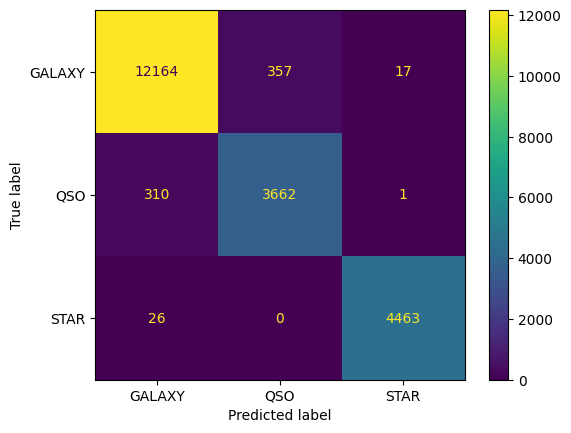

In [63]:
clf = tree.DecisionTreeClassifier(random_state=80)
# clf = RandomForestClassifier(n_estimators=100)
feature_pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering),
    ('classifier', clf)
])

feature_pipeline.fit(X_train, y_train.values.ravel())
y_pred = feature_pipeline.predict(X_val)
print(classification_report(y_val, y_pred, digits=3))
cm = confusion_matrix(y_val, y_pred, labels=feature_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=feature_pipeline.classes_)
disp.plot()

## Plotting feature importances

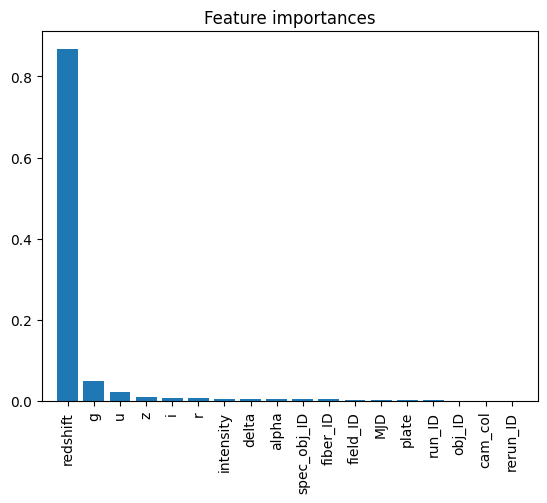

In [56]:
# Feature importance
importances = feature_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(features)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

new feature didn't help much:(

## Trying feature selection

In [57]:
sfm = SelectFromModel(tree.DecisionTreeClassifier(random_state=42), threshold=0.005)
sfm.fit(X_feature_engineered, y_train)
X_train_new = sfm.transform(X_feature_engineered)
X_val_new = sfm.transform(X_val_feature_engineered)
columns = X_train.columns[sfm.get_support()]
columns

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'intensity'], dtype='object')

              precision    recall  f1-score   support

      GALAXY      0.974     0.968     0.971     12538
         QSO      0.906     0.924     0.915      3973
        STAR      0.996     0.995     0.996      4489

    accuracy                          0.966     21000
   macro avg      0.959     0.962     0.960     21000
weighted avg      0.966     0.966     0.966     21000



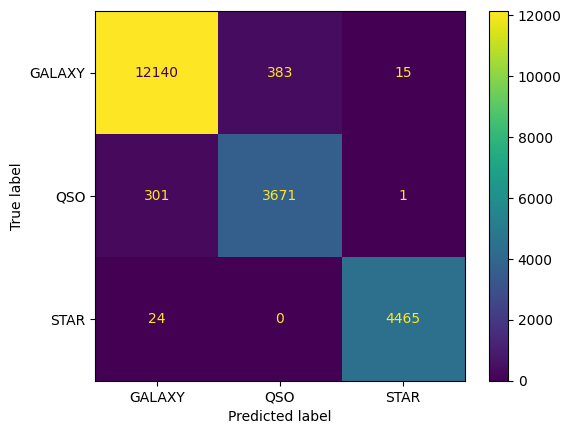

In [58]:
clf = tree.DecisionTreeClassifier(random_state=42)
# clf = RandomForestClassifier(n_estimators=100)
sfm = SelectFromModel(tree.DecisionTreeClassifier(random_state=42), threshold=0.005)
pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering),
    ('feature_selection', sfm),
    ('classifier', clf)
])

pipeline.fit(X_train, y_train.values.ravel())
y_pred = pipeline.predict(X_val)
print(classification_report(y_val, y_pred, digits=3))
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

to-do grid search

In [59]:
# grid = {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30]}
# clf = RandomForestClassifier()
# clf = GridSearchCV(clf, grid, cv=3, n_jobs=-1)
# clf = clf.fit(X_train, y_train)
# print(clf.best_params_)
# y_pred = clf.predict(X_val)
# print(classification_report(y_val, y_pred, digits=3))

## Full pipeline

              precision    recall  f1-score   support

      GALAXY      0.974     0.969     0.971     12538
         QSO      0.909     0.923     0.916      3973
        STAR      0.996     0.994     0.995      4489

    accuracy                          0.966     21000
   macro avg      0.959     0.962     0.961     21000
weighted avg      0.966     0.966     0.966     21000



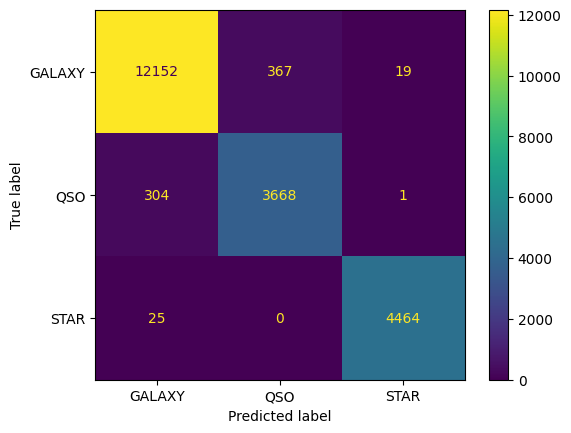

In [60]:
clf = tree.DecisionTreeClassifier(random_state=42)
# clf = RandomForestClassifier(n_estimators=100)
sfm = SelectFromModel(tree.DecisionTreeClassifier(random_state=42), threshold=0.005)

full_pipeline = Pipeline(steps=[
    ('feature_engineering', feature_engineering),
    ('scaler', StandardScaler()),
    ('feature_selection', sfm),
    ('classifier', clf)
])

full_pipeline.fit(X_train, y_train.values.ravel())
y_pred = full_pipeline.predict(X_val)
print(classification_report(y_val, y_pred, digits=3))
cm = confusion_matrix(y_val, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

## Roc curve

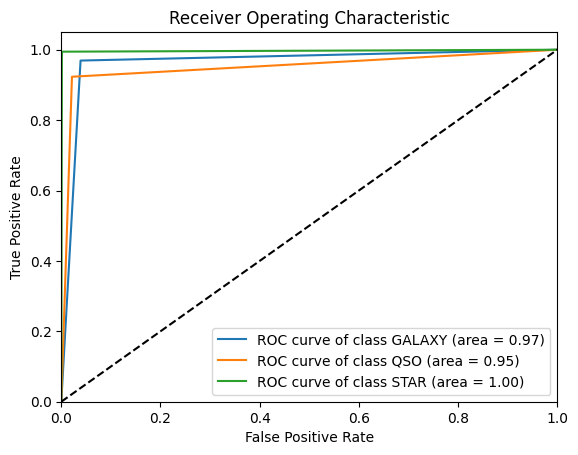

In [75]:
# for one tree model only 3 points
classes = full_pipeline.classes_
y_prob = full_pipeline.predict_proba(X_val)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val.values == classes[i], y_prob[:,i])
    roc_auc[i] = roc_auc_score(y_val.values == classes[i], y_prob[:,i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


c:\programowanie\sem6\ML_mini\.venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


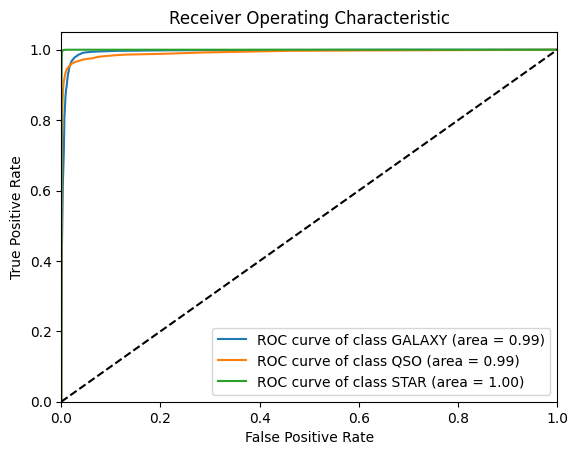

In [73]:
clf = tree.DecisionTreeClassifier()
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
classes = clf.classes_
y_prob = clf.predict_proba(X_val)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val.values == classes[i], y_prob[:,i])
    roc_auc[i] = roc_auc_score(y_val.values == classes[i], y_prob[:,i])
plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
